# Email Threat Detection System 🕵️‍♂️

It's not always easy to know whether a file you've downloaded and are preparing to execute is malicious.  How can we be better-prepared to tell the difference between benign and malicious executable files?

## The Goal:

Create a deep neural network, using tensorflow, with the intent on classifying image representations of portable executable files (PEs) so that, going forward, we can get a better understanding of the risk in opening files we get from unknown authors.

The 'benign' PEs were pulled from PC Magazine's [The Best Free Software of 2020](https://www.pcmag.com/news/best-free-software). The 'malicious' PEs were pulled from [the zoo](https://github.com/ytisf/theZoo).

Link to Kaggle dataset [here](https://www.kaggle.com/datasets/matthewfields/malware-as-images)!

## Prepare our workspace

Let's import our dependancies, confirm working versions of those dependancies, confirm runtime details such as presence of GPU, set random seeds, and list any workspace variables that we will likely reuse throughput the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub
import os
import shutil
import cv2
import datetime
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

2023-11-14 20:00:19.058615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('TF Version: ', tf.__version__)
print('TF Hub Version: ', hub.__version__)
print('Pandas Version: ', pd.__version__)
print('Numpy Version: ', np.__version__)

TF Version:  2.14.0
TF Hub Version:  0.15.0
Pandas Version:  1.5.3
Numpy Version:  1.24.3


### Create common variables

In [3]:
MEASUREMENT = 'lanczos'
DPI = "300"
IMAGE_SIZE = 224
WORKSPACE_BASE_URL = '../data/raw/'
PROCESSED_IMAGE_DIRECTORY = '../data/processed/processed_images'
RANDOM_STATE = 42

### Set random seeds for reproducability

In [4]:
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Create dataframe containing filenames and label as malicious

In [5]:
# create helper function to generate dataframe containing filnames and labels
def create_df(measurement=MEASUREMENT, dpi=DPI):
  """
  collect names of files according to measurement and DPI
  create dataframe for filenames and labels
  """
  # collect pathnames
  benign_path = f'{WORKSPACE_BASE_URL}/portable_executables/benign/{measurement}_{dpi}'
  malicious_path = f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{measurement}_{dpi}'
  # collect filenames
  benign_filenames = os.listdir(benign_path)
  malicious_filenames = os.listdir(malicious_path)
  # create dataframes
  df_benign = pd.DataFrame(benign_filenames, columns=['file_names'])
  df_malicious = pd.DataFrame(malicious_filenames, columns=['file_names'])
  # add labels
  df_benign['status'] = 'benign'
  df_malicious['status'] = 'malicious'
  # retrun concatonated dataframe
  return pd.concat([df_benign, df_malicious], ignore_index=True)

In [6]:
# create a dataframe
df = create_df()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_names  137 non-null    object
 1   status      137 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB


In [7]:
# confirm there are no duplicates
len(df[df.duplicated()]) == 0

True

<Axes: >

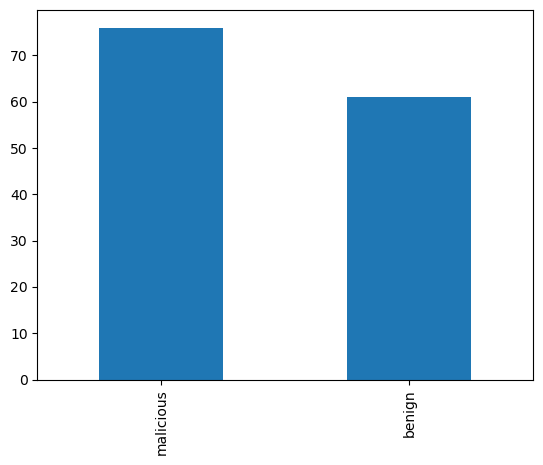

In [8]:
# check the balance of labels
df['status'].value_counts().plot(kind='bar')

These label counts are slightly off balance, but not to the extent that this should pose a serious problem.

We may want to circle back in our `create_df` helper function to ensure these classes are properly balanced.

### Visualizing our data

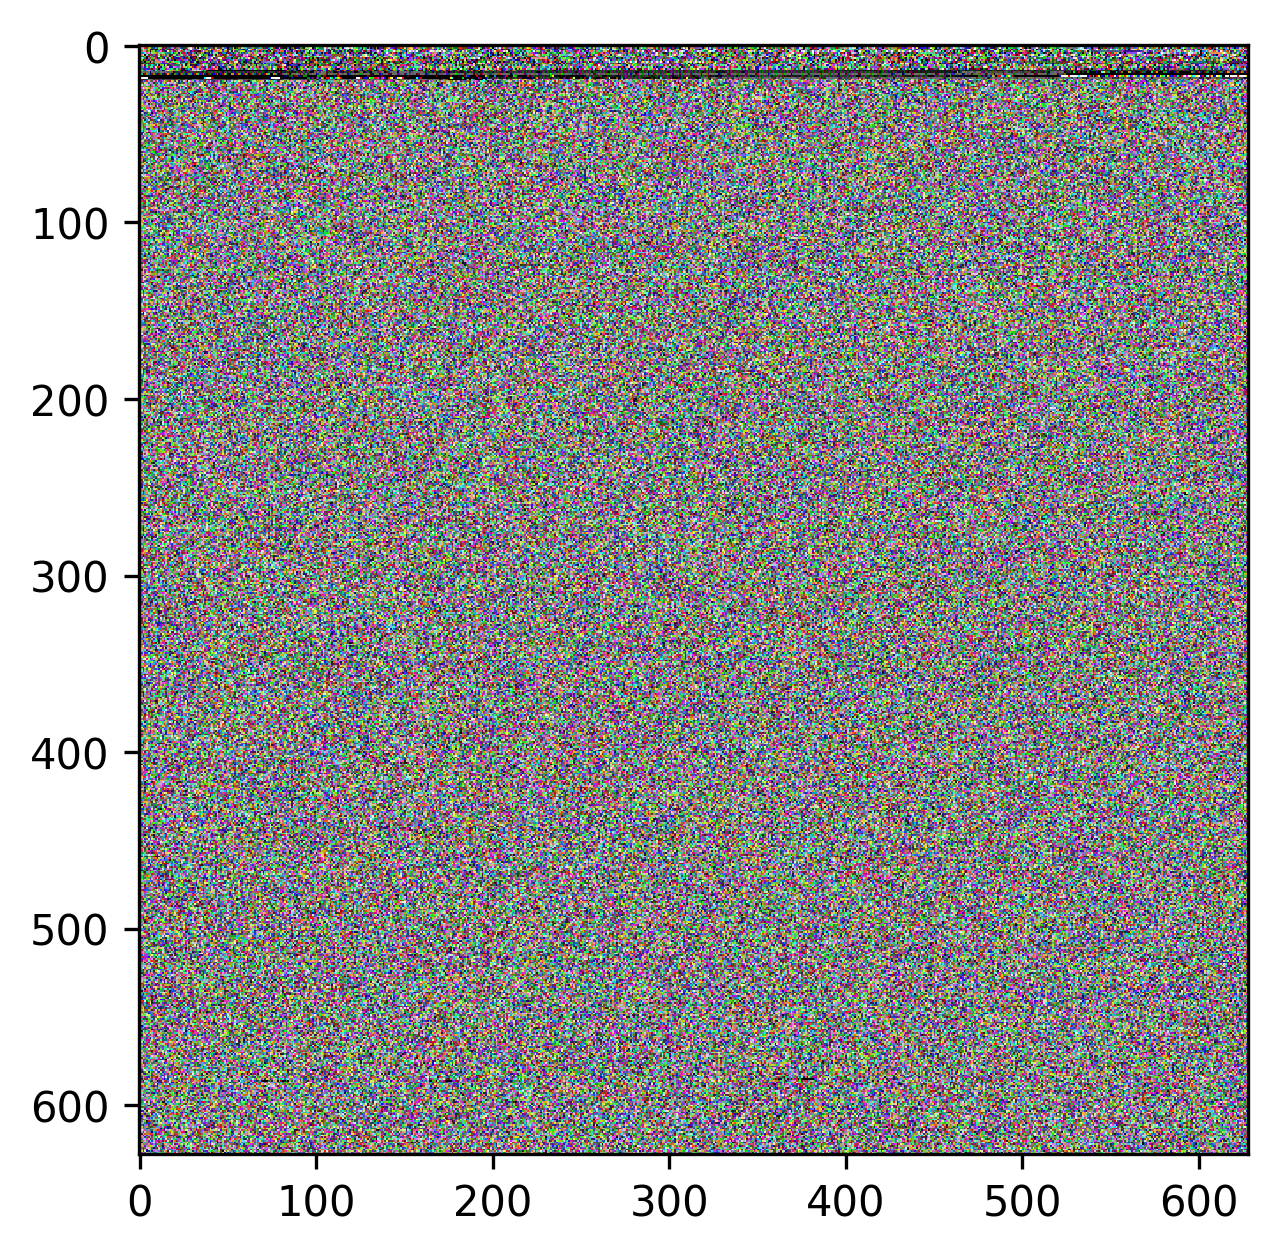

In [21]:
# Let's view an image within the notebook
from IPython.display import Image
Image(f"{WORKSPACE_BASE_URL}/portable_executables/benign/nearest_300/7z1900_nearest_300_.png")

This is a fairly large image.  We will likley have to downscale it and force dimension sizes on it.

Also, these images contain axis and margins that may confuse our model.  Perhaps we can strip these axis away?

In [10]:
# let's create a helper function to preprocess these images and put them in a common directory
def process_images(
    measurement=MEASUREMENT,
    dpi=DPI,
    size=(IMAGE_SIZE, IMAGE_SIZE),
    trim_axis=True
):
  """
  gathers image files from both benign and malicious file directories,
  optionally remove axis imformation from the image
  resize the image to desired width & height
  distribute all files in processed images directory
  """
  # collect source directories
  source_dirs = [
      f'{WORKSPACE_BASE_URL}/portable_executables/benign/{measurement}_{dpi}',
      f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{measurement}_{dpi}'
  ]
  # create destination directory
  destination_dir = PROCESSED_IMAGE_DIRECTORY

  # Ensure the destination directory exists, create if it doesn't
  if not os.path.exists(destination_dir):
      os.makedirs(destination_dir)

  # process each image
  for source_dir in source_dirs:
    for file_name in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file_name)

        # Check if it's a file and not a directory
        if os.path.isfile(file_path):
            # Read the image
            image = cv2.imread(file_path)

            # optionally remove axis from image
            if trim_axis:
              # Convert to grayscale and threshold to isolate the spectrogram
              gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              _, thresholded = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

              # Find contours and get the largest one which should be the spectrogram
              contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
              largest_contour = max(contours, key=cv2.contourArea)

              # Get bounding box of the largest contour
              x, y, w, h = cv2.boundingRect(largest_contour)

              # Crop the image to the bounding box
              image = image[y:y+h, x:x+w]

            # Resize the cropped image
            resized_image = cv2.resize(image, size)

            # Save the processed image to the destination directory
            cv2.imwrite(os.path.join(destination_dir, file_name), resized_image)


In [11]:
process_images()

now that we have our images processed, let's update our dataframe to include the base path for that processed images directory

In [12]:
df.head(3)

file_names  status
0        scribus-1.4.8-windows_lanczos_300_.png  benign
1  Boxcryptor_v2.42.1333_Setup_lanczos_300_.png  benign
2                  MYKI-latest_lanczos_300_.png  benign

In [13]:
df['file_names'] = f"{PROCESSED_IMAGE_DIRECTORY}/" + df['file_names']

In [14]:
df.head(3)

file_names  status
0  ../data/processed/processed_images/scribus-1.4...  benign
1  ../data/processed/processed_images/Boxcryptor_...  benign
2  ../data/processed/processed_images/MYKI-latest...  benign

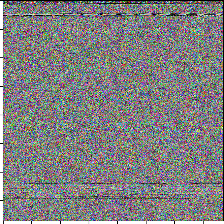

In [22]:
# let's view one of our processed images
impath = f'{PROCESSED_IMAGE_DIRECTORY}/Tojan.NSIS.Win32_lanczos_300_.png'
Image(impath)

In [16]:
# Let's check if the number of entries we have in our dataframe
# match the number of images we just processed
filenames = os.listdir(PROCESSED_IMAGE_DIRECTORY)
if len(df) == len(filenames):
    print('it matches -- proceed!')
else:
  print('they do not match -- check for error!')

they do not match -- check for error!


In [17]:
df.head()

file_names  status
0  ../data/processed/processed_images/scribus-1.4...  benign
1  ../data/processed/processed_images/Boxcryptor_...  benign
2  ../data/processed/processed_images/MYKI-latest...  benign
3  ../data/processed/processed_images/ks4.021.2.1...  benign
4  ../data/processed/processed_images/unchecky_se...  benign

In [23]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)

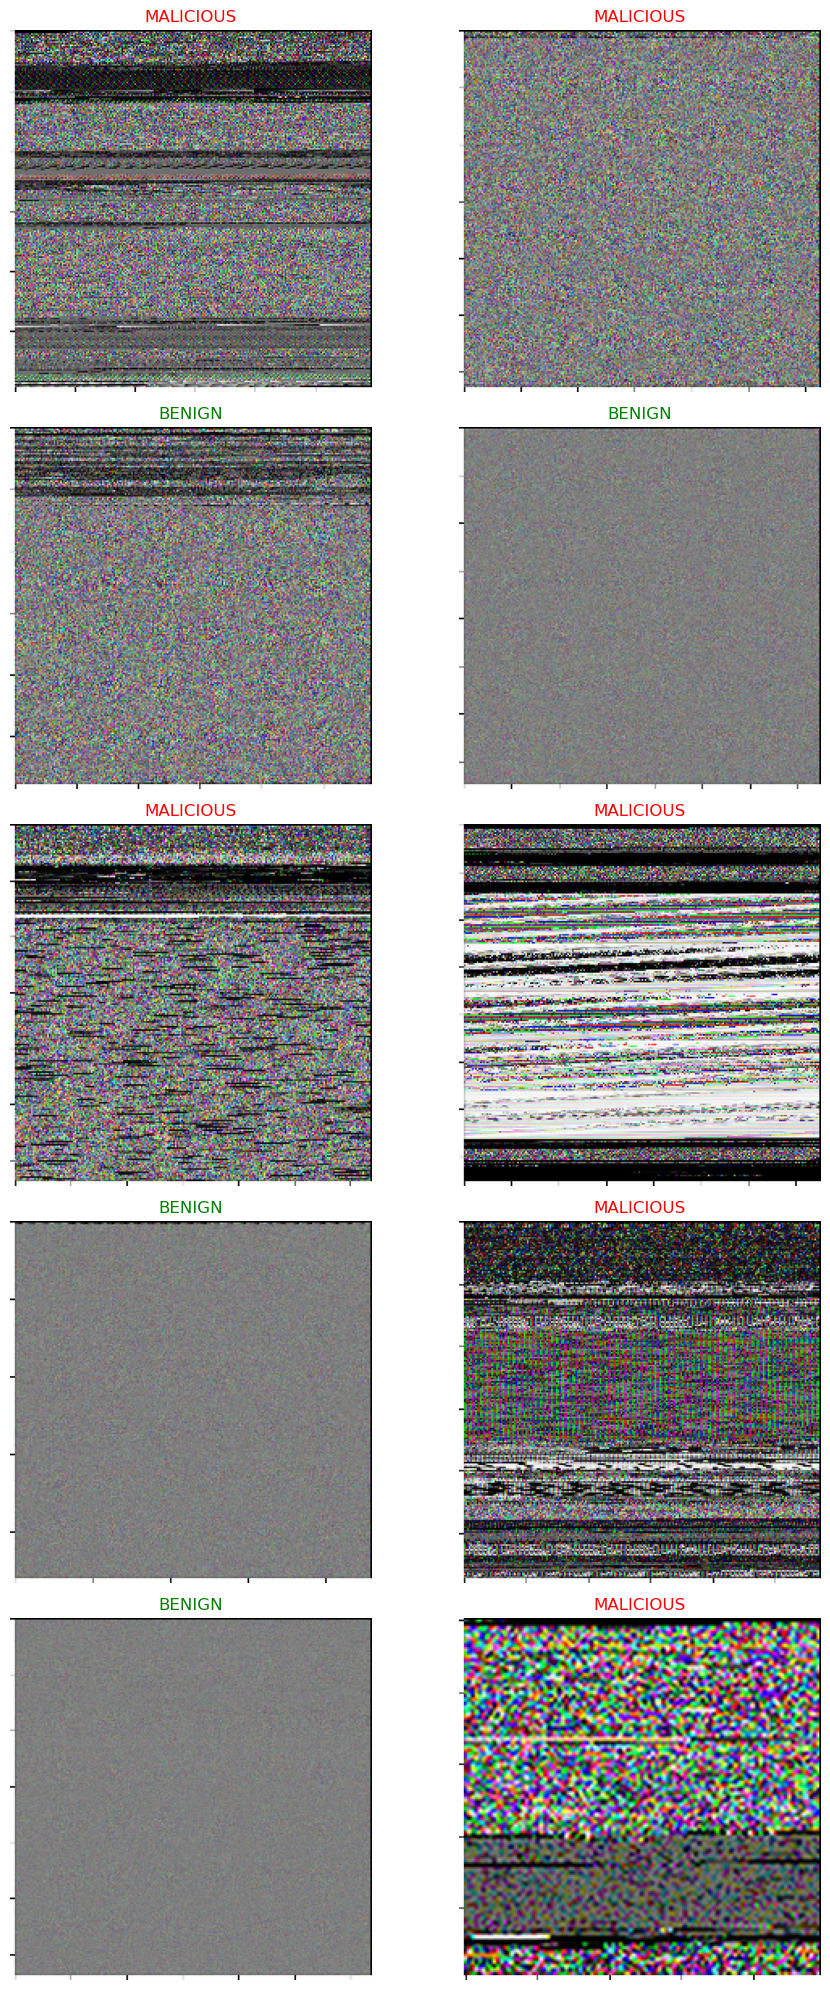

In [24]:
# Create a grid for plotting (5 rows, 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

# Flatten the axes array for easy iteration
axs = axs.ravel()

# Loop over the first 10 rows of the DataFrame
for idx, row in enumerate(shuffled_df.head(10).itertuples()):
    file_name = getattr(row, 'file_names')
    is_malicious = getattr(row, 'status') == 'malicious'

    # Load and display the image
    img = mpimg.imread(file_name)
    axs[idx].imshow(img)
    axs[idx].axis('off')  # Turn off axis

    # Display label
    label = "MALICIOUS" if is_malicious == True else "BENIGN"
    color = 'red' if is_malicious == True else 'green'
    axs[idx].set_title(f"{label}", color=color)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Create our own train, valid and test sets

now that we know the image paths we have in our dataframe can be accessed, we now need to create train and test sets